# CNN Cancer Detection Kaggle Mini-Project
## by: Kevin Boyle (CU-Boulder MS-DS)

### Brief Description of the Problem and Data

Hello! In this project, I will attempt to train a deep learning model utilizing a convolutional neural network (CNN) to identify metastatic cancer in small image patches taken from larger digital pathology scans. 

Since there is so much human error involved with doctors looking at pathology scans to diagnose cancer, the hope with advances in technology is that we can use deep learning to supplement doctor opinion and allow doctors to have the tools to make the most informed decisions.

Once analyzing the data using various EDA tools and visualiation, we will train the model on the dataset, and then determine accuracy of the model. Our goal is that accuracy is high enough that the model would be a good supplement for doctors in their diagnoses of cancer patients.

The dataset is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset, which is available for download from Kaggle here: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

In this dataset, I am given a large number of small pathology images to classify. The original PCam dataset contains duplicate images, however, the version presented on Kaggle does not contain duplicates. 

I will start the project by importing all useful packages as well as the dataset into the Jupyter notebook.

In [72]:
import numpy as np 
import pandas as pd 
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.legacy import RMSprop

In [55]:
#get files
test_path = '../downloads/histopathologic-cancer-detection/test/'
train_path = '../downloads/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('sample_submission.csv')
train_data = pd.read_csv('train_labels.csv')

### Exploratory Data Analysis (EDA)

Now, with the training data uploaded, I will explore the data a bit. I will start by checking out the info() and a few other descriptive tables and seeing what I can find.

In [56]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [57]:
train_data.head(20)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


From these two commands, I can see that the training data has two columns: an identifier that matches the ID of the image. There is also a label, that is a binary 0 or 1, which describes if the image contains a picture of a cancer (1) or not (0). In looking at info(), you can see there are 220,025 images in the training data, and there is no non-null information. Therefore, each image has a definite label about whether or not the image is an image of cancer, without the possibility of nulls.

Next, I am going to visualize the data.

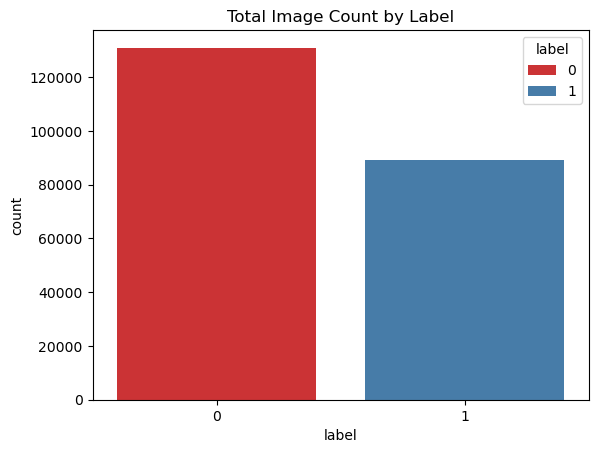

In [58]:
sns.countplot(x=train_data['label'], 
              hue=train_data['label'], 
              palette="Set1").set(title='Total Image Count by Label');

With this histogram above, we can visualize that there are more non-cancerous images than those that contain cancer. We will keep this in mind when training our model!

### Describe Model Architecture

As the title suggests, I will be using a convolutional neural network (CNN) for this model. I will be utilizing tensorflow, and in particular the keras package within, to initialize, parameterize, and train the model.

In our week 4 lectures, we were taught that the typical CNN architecture utilizes a convolutional layer, a convolutional layer, and then a max pool, and repeats that n times.

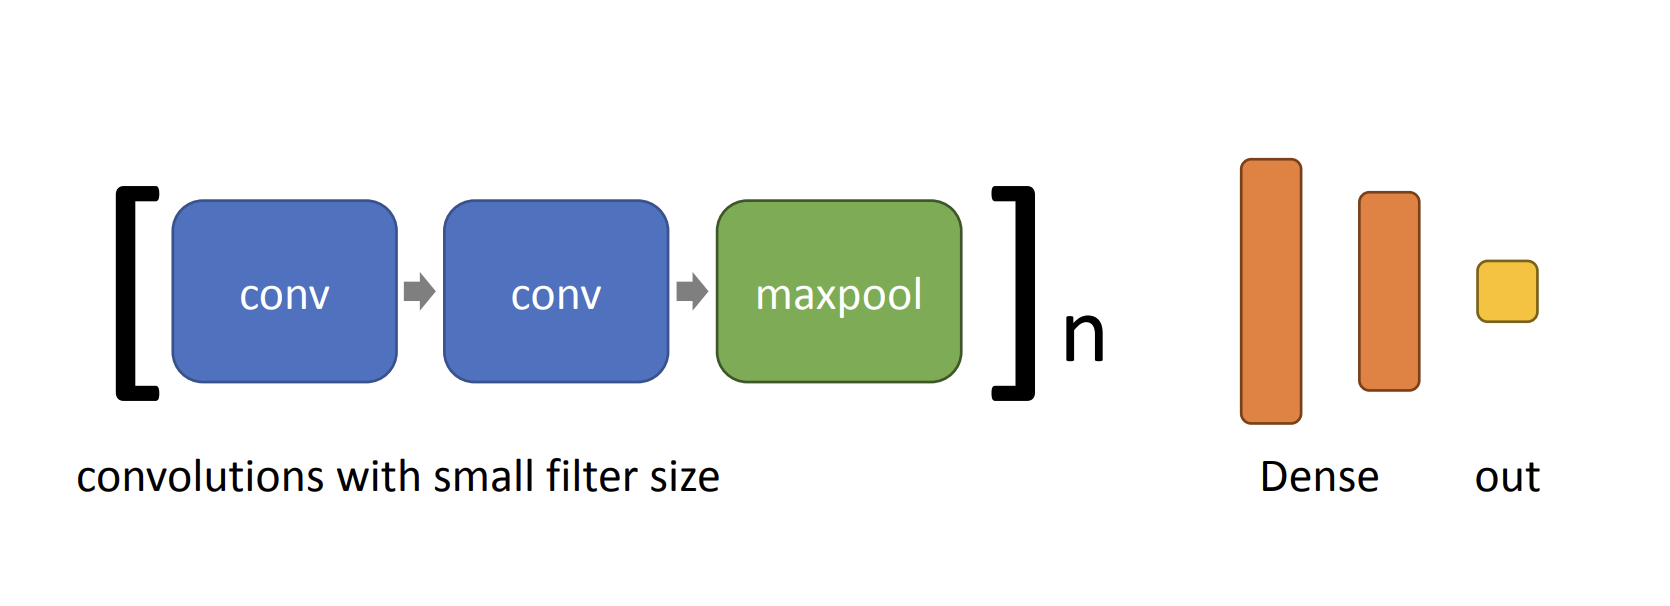

For my baseline model, I am going to have n = 2 for the purpose of my model. After the 2 repetitions occur, there is a flatten sequence and then output with an activation function. For the purpose of the model, I will utilize a sigmoid output function.

After training it and determining the accuracy result, I will see what I can do using tuning and optimization to try to get a better result for the architecture in question!

### Results and Analysis

To start, we will add ".tif" to the end of the IDs to create file names, and then split up the data into training data and validation data. We do this by using Keras flow_from_dataframe. I will also pre-training normalization of  the data by rescaling by 1 over 255.

In [59]:
def add_extension(id):
    return id + ".tif"

train_data['id'] = train_data['id'].apply(add_extension)
train_data['label'] = train_data['label'].astype(str)

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

#train data
train_generator = datagen.flow_from_dataframe(dataframe = train_data,
                                              directory = train_path,
                                              x_col = "id",
                                              y_col = "label",
                                              subset = "training",
                                              batch_size = 32,
                                              seed = 42,
                                              class_mode = "binary",
                                              target_size = (32,32)) 

#validation data
valid_generator = datagen.flow_from_dataframe(dataframe = train_data,
                                              directory = train_path,
                                              x_col = "id",
                                              y_col = "label",
                                              subset = "validation",
                                              batch_size = 32,
                                              seed = 42,
                                              class_mode = "binary",
                                              target_size = (32,32))  

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


Now we will create model one (baseline).

In [60]:
# create model
model_base = Sequential()
model_base.add(Conv2D(16, (3,3)))
model_base.add(Conv2D(16, (3,3)))
model_base.add(MaxPooling2D(pool_size = (2,2)))               
model_base.add(Conv2D(16, (3,3)))
model_base.add(Conv2D(16, (3,3)))
model_base.add(MaxPooling2D(pool_size = (2,2)))  
model_base.add(Flatten())
model_base.add(Dense(1,activation='sigmoid'))

# build and compile model
model_base.build(input_shape=(32, 32, 32, 3))
model_base.compile(loss="binary_crossentropy",metrics=["accuracy"])

#print out summary of model below
model_base.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (32, 30, 30, 16)          448       
                                                                 
 conv2d_27 (Conv2D)          (32, 28, 28, 16)          2320      
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 14, 14, 16)          0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (32, 12, 12, 16)          2320      
                                                                 
 conv2d_29 (Conv2D)          (32, 10, 10, 16)          2320      
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 5, 5, 16)            0         
 ng2D)                                                

We will now fit the model and train it. We will use 10 epochs.

In [61]:
# train the model
train_model = model_base.fit(
                        train_generator,
                        epochs = 10,
                        validation_data = valid_generator)

Epoch 1/10
5157/5157 [==============================] - 93s 18ms/step - loss: 0.5334 - accuracy: 0.7400 - val_loss: 0.4752 - val_accuracy: 0.7820
Epoch 2/10
5157/5157 [==============================] - 91s 18ms/step - loss: 0.4713 - accuracy: 0.7831 - val_loss: 0.4464 - val_accuracy: 0.8000
Epoch 3/10
5157/5157 [==============================] - 92s 18ms/step - loss: 0.4570 - accuracy: 0.7923 - val_loss: 0.5095 - val_accuracy: 0.7546
Epoch 4/10
5157/5157 [==============================] - 94s 18ms/step - loss: 0.4511 - accuracy: 0.7949 - val_loss: 0.4449 - val_accuracy: 0.7994
Epoch 5/10
5157/5157 [==============================] - 92s 18ms/step - loss: 0.4455 - accuracy: 0.7987 - val_loss: 0.4421 - val_accuracy: 0.7986
Epoch 6/10
5157/5157 [==============================] - 92s 18ms/step - loss: 0.4419 - accuracy: 0.8004 - val_loss: 0.4536 - val_accuracy: 0.7949
Epoch 7/10
5157/5157 [==============================] - 93s 18ms/step - loss: 0.4385 - accuracy: 0.8016 - val_loss: 0.4385 -

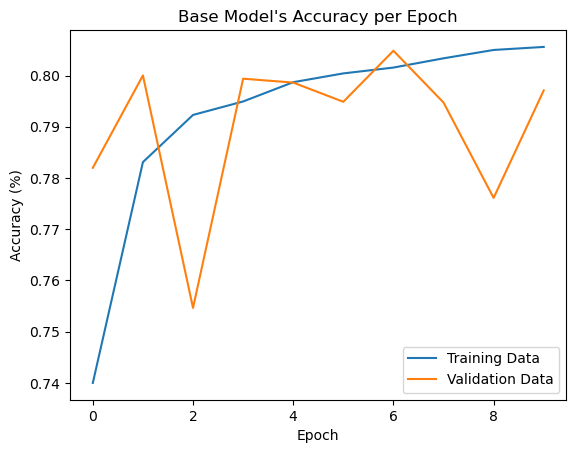

In [62]:
# plot model accuracy per epoch 
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title("Base Model's Accuracy per Epoch")
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Validation Data'])
plt.show();

Based on the baseline model, with minimal optimization or consideration of parameters, we achieved around 80.6% accuracy on the training data and 79.7% accuracy on the validation data. That is good, but let's see if we can get even better!

I will now create a modified model to the base model with a few tweaks to hopefully optimize further. The tweaks I will make will be:
* I will add a relu activation after each Convolutional 2D layer.
* Add a dropout layer of 0.25 after each maxpool.
* I will use RMSProp optimization.
* I will utilize a learning rate of 0.0001.

Let's see if all of these steps improve the model's accuracy on testing/validation data.

In [63]:
# create model
model_opt = Sequential()
model_opt.add(Conv2D(16, (3,3), activation='relu'))
model_opt.add(Conv2D(16, (3,3), activation='relu'))
model_opt.add(MaxPooling2D(pool_size = (2,2))) 
model_opt.add(Dropout(0.25))

model_opt.add(Conv2D(16, (3,3), activation='relu'))
model_opt.add(Conv2D(16, (3,3), activation='relu'))
model_opt.add(MaxPooling2D(pool_size = (2,2)))  
model_opt.add(Dropout(0.25))

model_opt.add(Flatten())
model_opt.add(Dense(1,activation='sigmoid'))

# build and compile model
model_opt.build(input_shape = (32, 32, 32, 3))
model_opt.compile(RMSprop(learning_rate = 0.0001),loss="binary_crossentropy",metrics=["accuracy"])

#print out summary of model below
model_opt.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (32, 30, 30, 16)          448       
                                                                 
 conv2d_31 (Conv2D)          (32, 28, 28, 16)          2320      
                                                                 
 max_pooling2d_14 (MaxPooli  (32, 14, 14, 16)          0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (32, 14, 14, 16)          0         
                                                                 
 conv2d_32 (Conv2D)          (32, 12, 12, 16)          2320      
                                                                 
 conv2d_33 (Conv2D)          (32, 10, 10, 16)          2320      
                                                      

Once again, we will train/fit the model on 10 epochs.

In [64]:
# train the model
train_model = model_opt.fit(
                        train_generator,
                        epochs = 10,
                        validation_data = valid_generator)

Epoch 1/10
5157/5157 [==============================] - 95s 18ms/step - loss: 0.5078 - accuracy: 0.7524 - val_loss: 0.4809 - val_accuracy: 0.7741
Epoch 2/10
5157/5157 [==============================] - 93s 18ms/step - loss: 0.4674 - accuracy: 0.7850 - val_loss: 0.4700 - val_accuracy: 0.7802
Epoch 3/10
5157/5157 [==============================] - 93s 18ms/step - loss: 0.4553 - accuracy: 0.7910 - val_loss: 0.4682 - val_accuracy: 0.7800
Epoch 4/10
5157/5157 [==============================] - 95s 18ms/step - loss: 0.4431 - accuracy: 0.7975 - val_loss: 0.4409 - val_accuracy: 0.8003
Epoch 5/10
5157/5157 [==============================] - 93s 18ms/step - loss: 0.4312 - accuracy: 0.8047 - val_loss: 0.4278 - val_accuracy: 0.8068
Epoch 6/10
5157/5157 [==============================] - 92s 18ms/step - loss: 0.4150 - accuracy: 0.8142 - val_loss: 0.4024 - val_accuracy: 0.8250
Epoch 7/10
5157/5157 [==============================] - 92s 18ms/step - loss: 0.4038 - accuracy: 0.8208 - val_loss: 0.4139 -

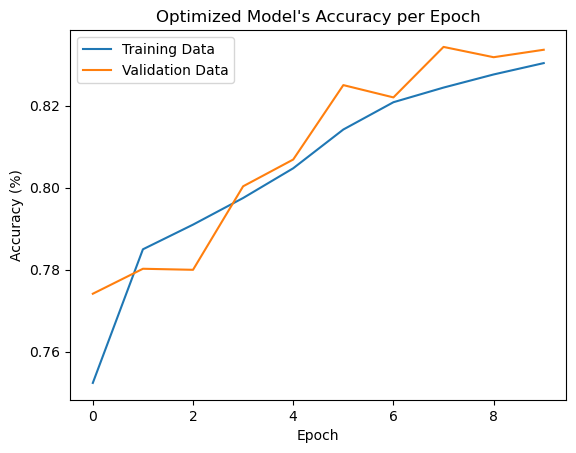

In [65]:
# plot model accuracy per epoch 
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title("Optimized Model's Accuracy per Epoch")
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Validation Data'])
plt.show();

We have gotten a bit better on this one, up to around 83% accuracy at its peak for both training and validation data. I feel pretty satisfied with that result, so now I will try to run this trained model against the test data to truly see how it holds up!

In [66]:
# Dataframe of file names in the test path
df = pd.DataFrame({'id':os.listdir(test_path)})

# Create a test generator with those file names
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe = df,
    directory = test_path,
    x_col = 'id', 
    y_col = None,
    batch_size = 32,
    class_mode = None,
    target_size = (32,32))

Found 57458 validated image filenames.


In [67]:
# Now I am going to run predictions on the optimized model.

preds = model_opt.predict(test_generator, verbose = 1)

1796/1796 [==============================] - 22s 12ms/step


In [68]:
print(preds)

[[0.73315066]
 [0.92083836]
 [0.08148339]
 ...
 [0.15003921]
 [0.4190509 ]
 [0.27994576]]


As you can see, in the prediction array, we get values from 0 to 1. Since we are using a sigmoid activation function, we are going to say that anything less than 0.5 should be classified as a 0, and everything greater than 0.5 should be classified as a 1. Then, I will map those prediction labels to the file names and create my submission dataframe (which will then in turn become my submission csv).

In [69]:
for x in range(len(preds)):
    if preds[x] < 0.5:
        preds[x] = 0
    else:
        preds[x] = 1

print(preds)

[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [70]:
submission = pd.DataFrame(columns=['id', 'label'],index=range(0, 57458))

for x in range(len(submission)):
    submission['id'][x] = df['id'][x].replace(".tif", "")
    submission['label'][x] = preds[x]

print(submission)

                                             id label
0      fd0a060ef9c30c9a83f6b4bfb568db74b099154d   1.0
1      1f9ee06f06d329eb7902a2e03ab3835dd0484581   1.0
2      19709bec800f372d0b1d085da6933dd3ef108846   0.0
3      7a34fc34523063f13f0617f7518a0330f6187bd3   0.0
4      93be720ca2b95fe2126cf2e1ed752bd759e9b0ed   0.0
...                                         ...   ...
57453  2581931c6ef068f105a872f2c5500275fc678242   1.0
57454  11b250a664d09ab59fd2afbdb2f8d786763b185d   0.0
57455  18a6030935ec1ef1ce486ec51bc95abb4008fbf1   0.0
57456  f541404e501e23a0188c852eb37eac94053cfdc0   0.0
57457  3cb6f5e2db8ad046c946b581fa12d20df5ce2927   0.0

[57458 rows x 2 columns]


In [71]:
submission.to_csv('submission_csv_opt.csv',index = False)

After submitting the file to Kaggle, I got the following scores:

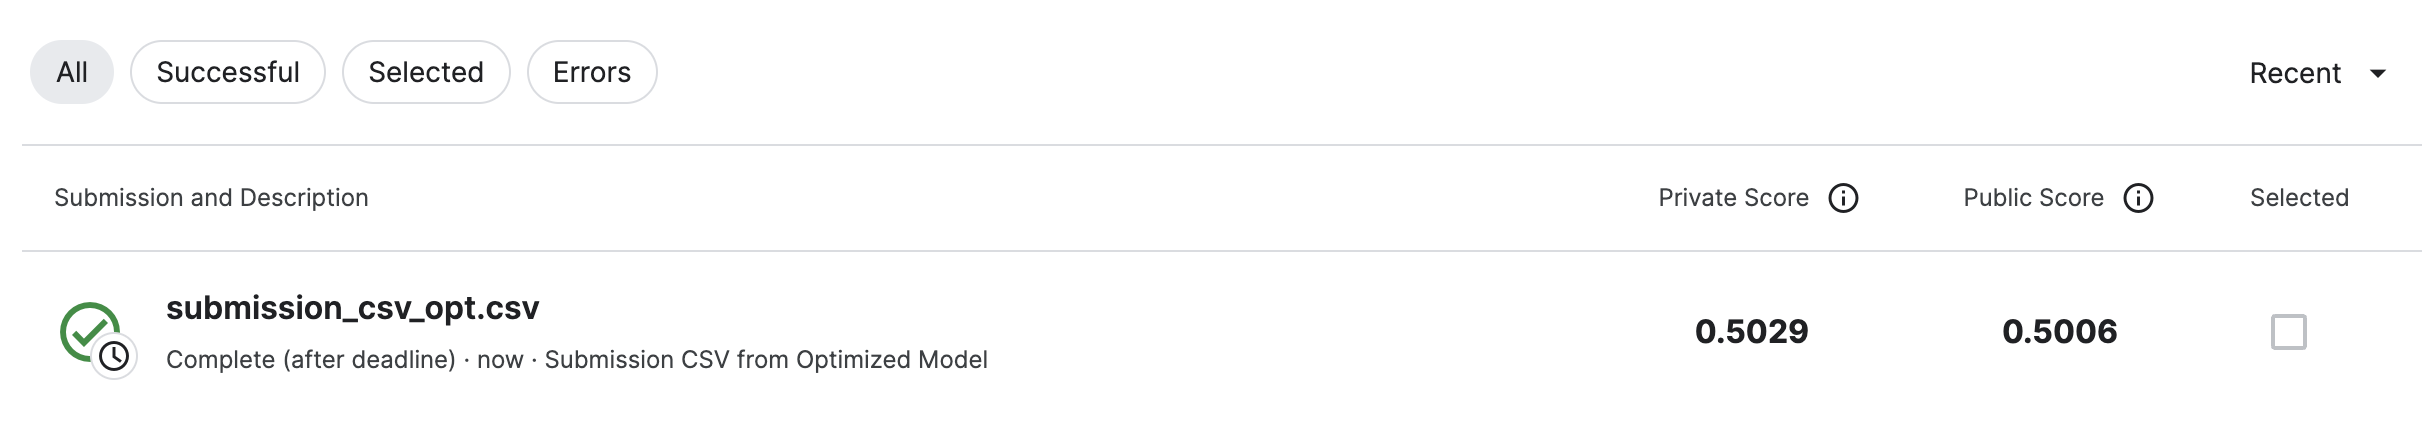

### Conclusion

In conclusion, we created multiple models to see how well we could do with this project. We created a baseline model, which had very minimal tuning of hyperparameters. The second model, which was more optimized, had extra layers, as well as extra activations, learning rate specified, and increased normalization of data. As expected, this second model did better, with about an 83% accuracy on the test and validation data sets.

In future iterations of this problem, I could do a few things differently to try to increase that accuracy. I could increase the amount of epochs, although you have to weigh that against possible overfitting. I could try to tweak other hyperparameters or use other optimization strategies such as Adam. In addition, I could also try having a more complex model with more sophisticated layers that are optimized in their own right.

I learned a lot during this assignment about the use and utility of CNN, and I can't wait to try other Kaggle projects to reinforce my knowledge.